In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlxtend.data as mld
import warnings as w
w.filterwarnings('ignore')
import glob
import pickle

In [3]:
train_data,train_label = mld.loadlocal_mnist(images_path='F:/Books/Machine Learning/DataSets/MNIST/train-images-mnist.idx3-ubyte', # extract zip file
                        labels_path='F:/Books/Machine Learning/DataSets/MNIST/train-labels-mnist.idx1-ubyte')

test_data,test_label = mld.loadlocal_mnist(images_path='F:/Books/Machine Learning/DataSets/MNIST/test-images-mnist.idx3-ubyte', # extract zip file
                        labels_path='F:/Books/Machine Learning/DataSets/MNIST/test-labels-mnist.idx1-ubyte')


In [4]:
train_data = train_data/train_data.max()
test_data = test_data/test_data.max()

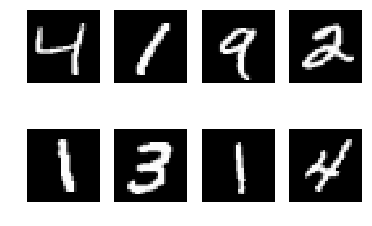

In [5]:
for i in range(1,9):
    plt.subplot(240+i)
    plt.axis('off')
    plt.imshow(train_data[1+i,:].reshape(28,28), cmap='gray')
plt.show()

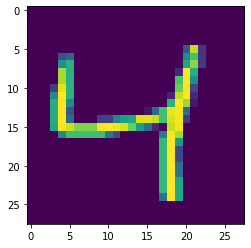

In [5]:
plt.imshow(train_data[2,:].reshape(28,28))

In [6]:
# Number of unique elements in datasets
len(np.unique(train_label))

10

In [8]:
class NeuralNetwork():
    
    def __init__(self):
        
        self.layers_n       = []
        self.theta_layers   = []
        self.bias           = []
        self.activation_func= []
        self.activations    = []
        self.dL_dA          = []
        self.dL_dtheta      = []
        self.dL_dbias       = []
        self.itera          = []
        self.csfun          = []
                
    def add(self , neuron , activation_function = 'relu'):
        '''You have to give the no. of neurons for a given layer.
            First layer neurons = no. of columns of your data
            
            default activation function is 'relu' you can change to 'sigmoid' , 'softmax' also
        '''
        self.layers_n.append(neuron)
        
        if activation_function == 'sigmoid' or activation_function == 'relu' or activation_function == 'softmax':
            self.activation_func.append(activation_function)
        else:
            raise TypeError('Pass only relu or sigmoid , and softmax for last layer')
    
    def one_hot_label(self , y):
        one_hot_labels = np.zeros((y.shape[0] , self.layers_n[-1]))
        for i in range(y.shape[0]):  
            one_hot_labels[i, y[i] ] = 1
        return one_hot_labels

    
    def fit(self , X , y , batch_size = 128 , alpha = 0.01 , epoche = 100,lmda = .01):
        for i in range(len(self.layers_n)-1): 
            self.theta_layers.append(np.random.randn(self.layers_n[i],self.layers_n[i+1]))
            
            self.bias.append((np.random.randn(self.layers_n[i+1])))
        
        return self.gradientDecent( X , y , batch_size , alpha , epoche )
    
    def softmax(self , activation , theta , bias):
        exp = np.exp( np.dot( activation , theta ) + bias)
        denominator = np.sum( exp , axis = 1)
        s = list(map(lambda i : exp[:,i] / denominator , np.arange(self.layers_n[-1])))
        return np.array(s).T
    
    def relu(self,activation,theta, bias):
        q = (np.dot(activation , theta) + bias)
        return np.clip(q , a_min=0 , a_max = q)
    
    def sigmoid(self, activation , theta , bias):
        return  1 / (1 + np.exp(np.dot(activation , theta) +  bias))
    
    def forwardPropagation(self,X):
        
        self.activations    = []
        self.activations.append(X)
        
        for i in range(len(self.layers_n)-2):
            self.activations.append(self.relu(self.activations[i] , self.theta_layers[i] , self.bias[i])) 
                      
        self.activations.append(self.softmax(self.activations[-1] , self.theta_layers[-1] , self.bias[-1]))
        
    def costFunction(self,X,y):
        
        self.y = self.one_hot_label(y)
        self.forwardPropagation(X)
        
        np.nan_to_num(self.activations[-1] , copy = False)
        self.crossEntropy = self.y * np.log(self.activations[-1])
        np.nan_to_num(self.crossEntropy, copy=False)
        
        #regu = self.lmda * (np.sum(self.theta_layer1)**2 + np.sum(self.theta_layer2)**2 + np.sum(self.theta_layer3)**2 + np.sum(self.theta_layer4)**2)
        return (1/X.shape[0] * -np.sum(self.crossEntropy)) #+ regu  # regu = 0 bcz lmda is zero 
      
    
    def costFunctionDerivative(self,X,y,alpha):
        
        self.dL_dA          = []
        self.dL_dtheta      = []
        self.dL_dbias       = []
        
        self.forwardPropagation(X)
        
        self.y_cap = self.activations[-1]
        self.target_y = self.one_hot_label(y)
        self.dL_dA.append(self.y_cap - self.target_y)
        
        for i in range(len(self.layers_n)-2):   
            
            self.dL_dA.append( np.dot( self.dL_dA[i] , self.theta_layers[-1-i].T ) )
        
        for i in range(len(self.layers_n)-1):  
            
            # Storing derivative in a list
            self.dL_dtheta.append(1/X.shape[0] * (np.dot(self.activations[-2-i].T , self.dL_dA[i]))) 
            self.dL_dbias.append(1/X.shape[0] * self.dL_dA[i])
        
        for i in range(len(self.layers_n)-1):  
            
            # updating parameters
            self.theta_layers[i]    -= (alpha * self.dL_dtheta[-1-i])  
            self.bias[-1-i]         -= (alpha * self.dL_dbias[i].sum(axis = 0))                  
            
            # dont get confuse by [-1-i] . Actually derivative are calculated during backpropagation
            # and original values are initialized during forward propagation so derivative are stored in
            # reverse order while data's stored in forward order
      
    def gradientDecent(self , X , y , batch , alpha , epoche  ):
        i = 1
        while i < epoche:
            
            index = np.random.randint(0 , X.shape[0] , size=(batch,))
        
            initial_cost = self.costFunction(X[index] , y[index] )
       
            self.costFunctionDerivative(X[index], y[index],alpha )
        
            #print('Iteration {} Cost function {}'.format(i , initial_cost ))    
        
            self.itera.append(i)
            self.csfun.append(initial_cost)
            i+=1
            
        final_cost = self.costFunction(X[index] , y[index] )
        self.itera.append(i)
        self.csfun.append(final_cost)
        print('Iteration {} Cost function {}'.format(i , initial_cost ))
        
            
    def gradient_plot(self):
        plt.plot(self.itera[10:],self.csfun[10:])
         
        
    def accuracy(self , X , y):
        self.forwardPropagation(X)
        pred = np.argmax(self.activations[-1],axis=1)
        c1 = 0
        for i,j in enumerate(y):
            if j == pred[i]:
                c1+=1
        print("Accuracy : ",(c1/y.shape[0])*100,'%')
        
    def predict(self,X):
        self.forwardPropagation(X)
        return np.argmax(self.activations[-1],axis = 1)
    
    def predict_prob(self,X):
        self.forwardPropagation(X)
        return self.activations[-1]
        


In [9]:
NN = NeuralNetwork()
NN.add(784)
NN.add(200)
NN.add(10)
NN.fit(train_data,train_label,alpha=0.099,epoche = 3500,batch_size = 2000)
# It takes a time approx. 1 minute [you can un-comment the print function in gradientDecent() to see what's going on]

Iteration 3500 Cost function 0.6673331034363847


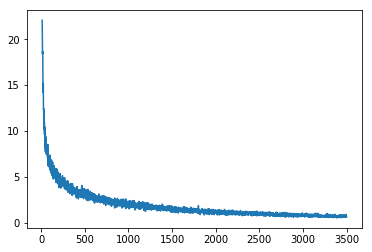

In [10]:
NN.gradient_plot()

In [11]:
NN.accuracy(test_data,test_label)
NN.accuracy(train_data,train_label)

Accuracy :  91.0 %
Accuracy :  92.20833333333334 %


# Lets look close what we find in first hidden layer network

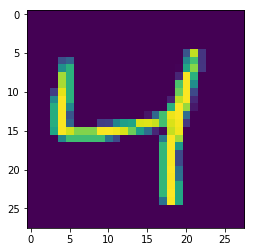

In [12]:
plt.imshow(train_data[2,:].reshape(28,28))

### How program see the feature pixels

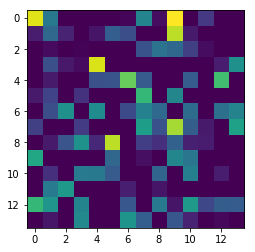

In [14]:
plt.imshow(NN.activations[1][2,:196].reshape(14,14))

# We trained our previous model with 200 neurons it's very small size of image if we resize them 
# Now i will pass 0,1,2 digits without shuffle with 1000 images 

In [15]:
inde5 = np.hstack(np.argwhere(train_label == 0))[:1000]
inde4 = np.hstack(np.argwhere(train_label == 1))[:1000]
inde3 = np.hstack(np.argwhere(train_label == 2))[:1000]

q = np.append(inde5,[inde4,inde3])

In [45]:
NN.accuracy(train_data[q],train_label[q])

Accuracy :  94.76666666666667 %


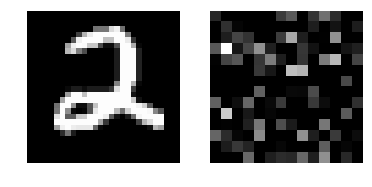

<Figure size 432x288 with 0 Axes>

In [21]:
import pylab as pl
import scipy.stats as s
from IPython import display
import time

for i in range(1,3000,30):
    f = plt.figure()    
    f.add_subplot(1,2, 1)
    plt.axis('off')
    plt.imshow(train_data[q][i,:].reshape(28,28), cmap='gray')
    f.add_subplot(1,2, 2)
    plt.axis('off')
    plt.imshow(NN.activations[-2][i,:196].reshape(14,14), cmap='gray')
    display.clear_output(wait=True)
    display.display(pl.gcf())
    f.clear()
    plt.show()

# Saving output as GIF

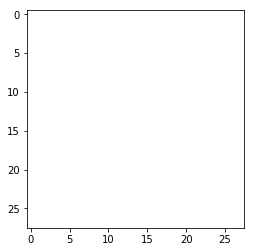

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

fig = plt.figure()
ims = []
for i in range(1,3000,30):
    im = plt.imshow(train_data[q][i,:].reshape(28,28), cmap='gray')
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval = 50, blit=True, repeat_delay=500)
writer = PillowWriter(fps=20)
ani_1.save("original.gif", writer=writer)


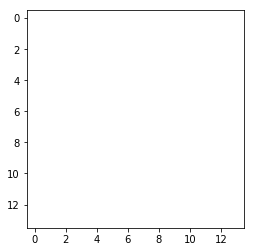

In [54]:
fig = plt.figure()
ims = []
for i in range(1,3000,30):
    im = plt.imshow(NN.activations[-2][i,:196].reshape(14,14), cmap='gray')
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval = 50, blit=True, repeat_delay=500)
writers = PillowWriter(fps=20)
ani_1.save("hiddenunitoutput.gif", writer=writers)